<a href="https://colab.research.google.com/github/jchen8000/DemystifyingLLMs/blob/main/5_Fine-Tuning/LoRA_En2De.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 5. Pre-Training

## 5.3 Low-Rank Adaptation (LoRA)

Another example of LoRA, fine-tune a English to German Translation Task

This script is tested on Google Colab with T4 GPU. This script uses the HuggingFace datasets, as a prerequisite you need a HuggingFace account and obtain a access token, see https://huggingface.co/docs/hub/security-tokens. You should add the token to Colab Secrets as HF_TOKEN to run this script.


In [ ]:
%pip install -q \
  numpy==2.0.2 \
  pandas==2.2.2 \
  matplotlib==3.10.0 \
  torch==2.10.0 \
  datasets==4.0.0 \
  transformers==4.57.3 \
  peft==0.18.0 \
  nltk==3.9.1

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import torch
from datasets import load_dataset, Dataset
from transformers import T5Tokenizer
from transformers import T5ForConditionalGeneration
from transformers import TrainingArguments
from transformers import Trainer
from transformers import GenerationConfig
from peft import LoraConfig, get_peft_model, TaskType
from nltk.translate.bleu_score import corpus_bleu, sentence_bleu, SmoothingFunction
import warnings

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
warnings.filterwarnings('ignore')

### Load FLAN-T5 Base model

In [ ]:
# model_name = 'google/flan-t5-base'
# lora_model_name = 'outputs/flan-t5-base_lora_en2de'
model_name = 'google/flan-t5-large'
lora_model_name = 'outputs/flan-t5-large_lora_en2de'

def load_model(model_name):
    tokenizer = T5Tokenizer.from_pretrained(model_name)
    model = T5ForConditionalGeneration.from_pretrained(model_name, torch_dtype=torch.bfloat16)
    return tokenizer, model

tokenizer, model = load_model(model_name)
total_parameter = sum(p.numel() for p in model.parameters())
print(f"Parameters of the model: {total_parameter:,}")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


config.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.13G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

Parameters of the model: 783,150,080


### Load Multi30k Dataset


In [ ]:
multi30k = load_dataset("bentrevett/multi30k")
print(multi30k)

Generating train split:   0%|          | 0/29000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1014 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['en', 'de'],
        num_rows: 29000
    })
    validation: Dataset({
        features: ['en', 'de'],
        num_rows: 1014
    })
    test: Dataset({
        features: ['en', 'de'],
        num_rows: 1000
    })
})


### Tokenize the dataset

In [ ]:
def tokenize_function(example):
  prompt = ["Translate English to German: " + s for s in example['en']]
  example['input_ids'] = tokenizer(prompt, padding="max_length", truncation=True, return_tensors="pt").input_ids
  example['labels'] = tokenizer(example['de'], padding="max_length", truncation=True, return_tensors="pt").input_ids
  return example

tokenized_datasets = multi30k.map(tokenize_function, batched=True)
print(tokenized_datasets)

Map:   0%|          | 0/29000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1014 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['en', 'de', 'input_ids', 'labels'],
        num_rows: 29000
    })
    validation: Dataset({
        features: ['en', 'de', 'input_ids', 'labels'],
        num_rows: 1014
    })
    test: Dataset({
        features: ['en', 'de', 'input_ids', 'labels'],
        num_rows: 1000
    })
})


### Preliminary evaluation by human assessment

In [ ]:
def generate_output(tokenizer, model, input_text, max_length=200):
    # Tokenize the input text and generate the model's output
    input_ids = tokenizer(input_text, return_tensors="pt").input_ids
    outputs = model.generate(
        input_ids=input_ids,
        generation_config=GenerationConfig(max_new_tokens=200, num_beams=1)
    )
    response = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return response

def calculate_bleu(tokenizer, reference, predicted):
    tokenized_pred = [tokenizer.tokenize(pred) for pred in predicted]
    tokenized_ref = [[tokenizer.tokenize(ref) for ref in refs] for refs in reference]
    chencherry = SmoothingFunction()
    bleu_score = corpus_bleu(
        tokenized_ref,
        tokenized_pred,
        smoothing_function=chencherry.method1
    )
    return bleu_score

Produce the output on the randomly selected data samples:

In [ ]:
outputs = []
references = []
for item in random.choices(list(tokenized_datasets['test']), k = 10):
    prompt = "Translate English to German: " + item['en']
    output = generate_output(tokenizer, model, prompt)
    outputs.append(output)
    references.append(item['de'])
    print("Prompt:", prompt)
    print("Target:", item['de'])
    print("Predict:", output)
    print()

bleu_score = calculate_bleu(tokenizer, references, outputs)
print(f"Average BLEU score: {bleu_score:.6f}")

Prompt: Translate English to German: A woman in a pink skirt is holding a baby.
Target: Eine Frau in einem rosa Rock hält ein Baby.
Predict: Ein Frauen in einem blauen Schnabel hält ein Baby.

Prompt: Translate English to German: Soccer players are jumping in the air to hit the ball with their heads.
Target: Fußballer springen in die Luft, um den Ball mit dem Kopf zu treffen.
Predict: Die Spieler schießen in der Luft, um den Ball mit ihren Kopf zu werfen.

Prompt: Translate English to German: The woman in blue is operating a camera in front of two other women.
Target: Die blau gekleidete Frau bedient eine Kamera vor zwei anderen Frauen.
Predict: Die Frau in blau steuert eine Kamera vor zwei andere Frauen.

Prompt: Translate English to German: A very young child in a denim baseball cap eats a green apple.
Target: Ein sehr kleines Kind mit einer Jeansmütze isst einen grünen Apfel.
Predict: Ein sehr junges Kind in einem denim-Badenkorps-Kassern nimmt ein grünes Apple.

Prompt: Translate E

### Fine-tuning with LoRA

In [ ]:
rank = 16
lora_config = LoraConfig(
    r=rank,
    lora_alpha=32,
    lora_dropout=0.05,
    bias="none",
    task_type=TaskType.SEQ_2_SEQ_LM  #FLAN-T5
)

In [ ]:
lora_model = get_peft_model(model, lora_config)
total_parameter = sum(p.numel() for p in lora_model.parameters())
lora_parameter = sum(p.numel() for p in lora_model.parameters() if p.requires_grad)
print(f"Total Parameters: {total_parameter:,}")
print(f"LoRA Parameters: {lora_parameter:,}; Percentage: {lora_parameter/total_parameter}")

Total Parameters: 787,868,672
LoRA Parameters: 4,718,592; Percentage: 0.005989059049678777


In [ ]:
# print(lora_model)

In [ ]:
max_steps = 300

lora_training_args = TrainingArguments(
    learning_rate=1e-3,
    auto_find_batch_size=True,
    logging_steps=1,
    max_steps=max_steps,
    report_to="none",
    output_dir = 'outputs' )

lora_triner = Trainer(
    model=lora_model,
    args=lora_training_args,
    train_dataset=tokenized_datasets['train'],
    )

lora_triner.train()

max_steps is given, it will override any value given in num_train_epochs


Step,Training Loss
1,40.500000
2,37.750000
3,35.500000
4,32.750000
5,30.625000
6,27.875000
7,26.125000
8,22.750000
9,20.375000
10,18.500000


TrainOutput(global_step=300, training_loss=2.190681966145833, metrics={'train_runtime': 581.3644, 'train_samples_per_second': 1.032, 'train_steps_per_second': 0.516, 'total_flos': 1391558079283200.0, 'train_loss': 2.190681966145833, 'epoch': 0.020689655172413793})

In [ ]:
lora_triner.save_model(lora_model_name)

### Visualize the fine-tuning

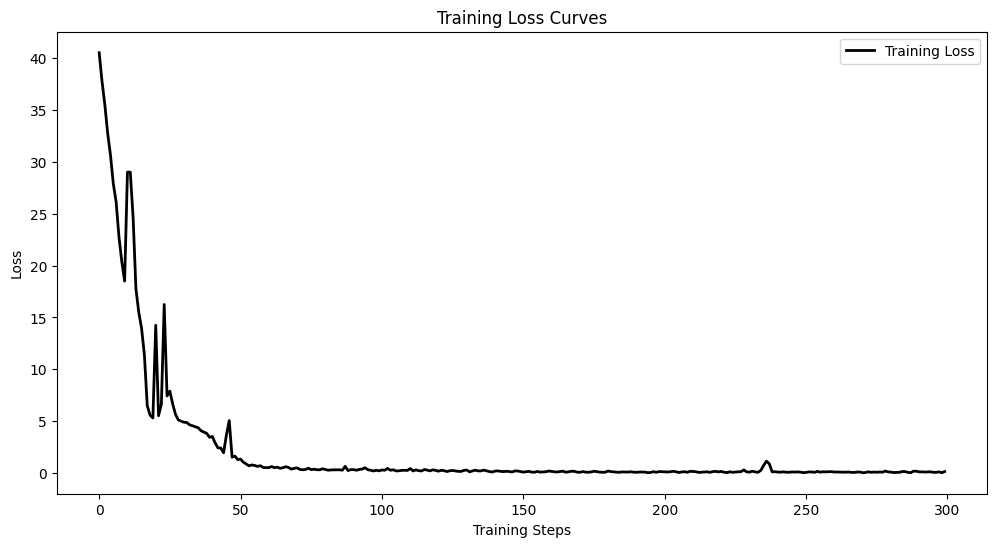

In [ ]:
log_history = lora_triner.state.log_history
df = pd.DataFrame(log_history)

if 'loss' in df.columns:
    df_filtered = df.dropna(subset=['loss'], how='all')
    df_filtered.reset_index(drop=True, inplace=True)

    plt.figure(figsize=(12, 6))
    plt.plot(df_filtered['loss'], lw=2, c='k', label='Training Loss')

    plt.title('Training Loss Curves')
    plt.xlabel('Training Steps')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig("outputs/fine-tuning.svg", format="svg", dpi=150, transparent=True, bbox_inches='tight')
    plt.show()

### Evaluation on the fine-tuned model

Load the saved fine-tuned model:

In [ ]:
from peft import PeftModel, PeftConfig
tokenizer, base_model = load_model(model_name)
peft_model = PeftModel.from_pretrained(base_model,
                                       lora_model_name,
                                       torch_dtype=torch.bfloat16,
                                       is_trainnable=False)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Evaluation with BLEU Scores:

In [ ]:
def calculate_bleu_score(tokenizer, reference, predicted):
    predicted_tokens = tokenizer.tokenize(predicted)
    reference_tokens = tokenizer.tokenize(reference)
    chencherry = SmoothingFunction()
    bleu_score = sentence_bleu(
        [reference_tokens],
        predicted_tokens,
        smoothing_function=chencherry.method1
    )
    return bleu_score

In [ ]:
outputs = []
references = []
for item in random.choices(list(tokenized_datasets['test']), k = 10):
    prompt = "Translate English to German: " + item['en']
    output = generate_output(tokenizer, peft_model, prompt)
    outputs.append(output)
    references.append(item['de'])
    bleu_score = calculate_bleu_score(tokenizer, item['de'], output)
    print("Prompt:", prompt)
    print("Target:", item['de'])
    print("Predict:", output)
    print(f"Average BLEU score: {bleu_score:.6f}")
    print()

bleu_score = calculate_bleu(tokenizer, references, outputs)
print(f"Average BLEU score: {bleu_score:.6f}")

Prompt: Translate English to German: In this photo there is a family of four dashing across a busy street in the city.
Target: Auf diesem Foto eilt eine vierköpfige Familie über eine geschäftige Straße in der Stadt.
Predict: In diesem Foto gibt es eine Familie von vier Familien, die sich auf einem Geschäft in der Stadt fahren.
Average BLEU score: 0.074657

Prompt: Translate English to German: A woman in a pink sweater and an apron, cleaning a table with a sponge.
Target: Eine Frau in einem pinken Pulli und einer Schürze putzt einen Tisch mit einem Schwamm.
Predict: A woman in einem blauen Sweater und einem Apron, schreckende Table mit einem Sponge.
Average BLEU score: 0.024011

Prompt: Translate English to German: A brown-haired man in a green shirt plays a trumpet outdoors.
Target: Ein Mann mit braunen Haaren in einem grünen Hemd spielt im Freien Trompete.
Predict: Eine schwarze Haareseine in einem grünen T-Shirt spielt es auf der Terrasse.
Average BLEU score: 0.163319

Prompt: Transl